Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. SPDX-License-Identifier: MIT-0

# 3 - Defined Domain Question Answering
In this notebook, we will explore how to use Amazon Bedrock to determine the intent and key identifiers of a natural language question.  This information will then be provided to a templated openCypher query which will be executed against an Amazon Neptune database in a pattern known as Defined Domain Question Answering. 

To accomplish this we will use [LlamaIndex](https://www.llamaindex.ai/) and the [`CypherTemplateRetriever`](https://docs.llamaindex.ai/en/stable/module_guides/indexing/lpg_index_guide/#cyphertemplateretriever) to interact with Amazon Bedrock and Amazon neptune to process and answer the question.

In the last notebook we looked at how to use these tools to provide an open domain question answering to users.  However, in many real-world applications, while customers may want to ask completely open-ended questions of a data set, we as application developers need to ensure that only appropriate and safe questions are answered. 

For example, in a banking application, you may want to give users the ability to ask about their own transactions and account balance, but you certainly wouldn’t want to allow them to inquire about other users’ financial information.

To address these types of use cases, we can leverage a set of predefined domain questions which use an LLM and a set of predefined queries to be run by the application. Here, a large language model (LLM) is used to determine the intent of a question, validate if that question is allowed, and then extract key entities from the user’s natural language question. 

These extracted entities are then used as the parameters for a pre-defined, templated query. This approach gives the application developer the freedom to create optimized, secure queries with appropriate data access controls, while still providing users with a natural language interface on top of the underlying data.

By the end of this notebook we will have all the knowledge we need to complete updating our chatbot application's Defined Domain Question Answering functionality.

## Imports & Setup
The examples that follow are built using a few classes provided by LlamaIndex. We first need to import them.  We will also pull some configuration information from the notebook and get the graph identifier for our Neptune Analytics graph for later use.

In [ ]:
%pip install -qqq llama-index==0.11.16 llama-index-llms-bedrock llama-index-graph-stores-neptune llama-index-embeddings-bedrock llama-index-readers-file

<div class="alert alert-warning">
<strong>⚠️ Notice</strong><hr>
    
If a <code>Note</code> or <code>Error</code> message appears after installing these packages, you can safely ignore these version incompatabilities and/or message to restart the notebook kernel.
</div>

In [ ]:
# Configure LlamaIndex code
from llama_index.llms.bedrock import Bedrock
from llama_index.embeddings.bedrock import BedrockEmbedding
from llama_index.core.prompts import PromptTemplate

from llama_index.core import Settings
from llama_index.graph_stores.neptune import NeptuneAnalyticsPropertyGraphStore, NeptuneQueryException
from IPython.display import display

# Retrieve the configuration information for the notebook
import graph_notebook as gn
config = gn.configuration.get_config.get_config()
host = config.host.split('.')[0]

# Set environment variable for host for Streamlit App
import os
os.environ["HOST"] = host

# Setup nest to allow for reusing the event loop by LlamaIndex
# This is a required step when running in a Jupyter Notebook
import nest_asyncio
nest_asyncio.apply()

## Loading Data
Running the cell below will remove all data from the current graph and load the SBOM data to prepare the graph for running the remaining cells in the notebook.

In [ ]:
%%oc
MATCH (n) DETACH DELETE n
WITH collect(n) as cnt
CALL neptune.load({format: 'csv', source: 's3://aws-neptune-customer-samples-us-west-2/workshops/building_genai_apps_using_neptune/sbom_data/',format: 'csv'})
YIELD totalRecords
RETURN totalRecords

### The LLM we want to use today

In this notebook we will be using the Claude V3 Sonnet Large Language Model supported by Amazon Bedrock.

In [ ]:
model_id = 'anthropic.claude-3-sonnet-20240229-v1:0'
llm = Bedrock(model=model_id)

Settings.llm = llm
print(llm)

### Connect to the graph containing the data we want to query

We need to create a connection between LlamaIndex and the graph containing our SBOM data. As part of making this connection, the LlamaIndex classes will query the graph database (Neptune) and derive the schema of the graph. That schema will be used as part of the prompting that the model receives when we ask it to generate queries from questions.

In [ ]:
graph_store = NeptuneAnalyticsPropertyGraphStore(
    graph_identifier = host
)
print(graph_store)

## Now we are ready to ask some questions


To start we will be using the `CypherTemplateRetriever` class of the [PropertyGraphIndex](https://docs.llamaindex.ai/en/stable/module_guides/indexing/lpg_index_guide/) to determine the key entities of a question and run the pre-defined query.

The diagram below shows the common flow between a user, the LlamaIndex helper classes, an LLM, and Amazon Neptune.<br><br>

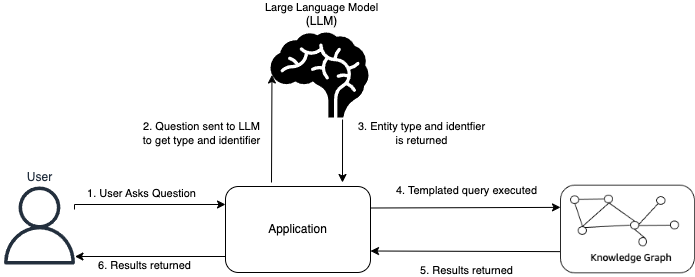

The `CypherTemplateRetriever` is the core component powering the knowledge graph retrieval capability in this system. This is an area where LlamaIndex does significant heavy lifting for us.
Here's how the retriever works:

1. When given a natural language question, the retriever combines the question with predefined template parameters.
2. It then provides this combined input to the language model (LLM), which extracts the relevant parameters from the question.
3. Once the parameters are extracted, the retriever incorporates them into a parameterized openCypher query template.
4. Finally, the retriever executes this query against the graph store and returns the results.

To set up the CypherTemplateRetriever, a few additional pieces need to be configured:

* The ComponentParams class: This is a [Pydantic BaseModel](https://docs.pydantic.dev/latest/api/base_model/) class that defines the expected parameters, along with a description for each. The LLM uses these descriptions to understand what values it needs to extract from the question.
* The parameterized openCypher query: This is the template query that will be executed, with the extracted parameters inserted as necessary.

In the example below, we’ll demonstrate how to extract the component name from the question and pass them as the $component_name parameter to the openCypher query during execution.

Let's start by creating our query, in this case we will create a query that finds the `Component` nodes in our graph based on the `name`.  When writing the query we must make this a paramerterized query, in this case the parameter is named `component_name` and is added to the query using `$component_name`.  You should also note that we will be doing a lowercase comparison on these values to provide a case-insensitive search.

In [ ]:
COMPONENT_QUERY = """
    MATCH (c:Component)
    WHERE toLower(c.name) = toLower($component_name)
    RETURN c as component
    """

Now that we have created our templated query we need to create a Pydantic BaseModel class that defines the expected parameters, along with a description for each. The LLM uses these descriptions to understand what values it needs to extract from the question.  For this example, we will specify that a parameter named `component_name` must exist and a description of the parameter.  

In [ ]:
from pydantic import BaseModel, Field

class ComponentParams(BaseModel):
    """Create a pydantic class to represent the params for our templated query.
        The class fields are directly used as params for running the cypher query.
    """

    component_name: str = Field(
        description="The component or library name to use for a start location of a query"
    )

The example is above is a basic form of the parameter class, consisting of only a single property, `component_name`, and a description.

Let’s see how we can use this in conjunction with our templated query to extract data from our graph.  To accomplish this we will create our `CypherTemplateRetriever` class and pass it our Neptune instance (i.e. `graph_store`), our parameter class (i.e. `ComponentParams`), and out templated query (i.e. `COMPONENT_QUERY`).

Once we have created our retriever we then pass a question into the `retrieve` method.

In [ ]:
from llama_index.core.indices.property_graph import CypherTemplateRetriever

retriever = CypherTemplateRetriever(graph_store, ComponentParams, COMPONENT_QUERY)

nodes = retriever.retrieve("Find me information about openldap?")
for node in nodes:
    print(node)

<div class="alert alert-warning">
    
<details>
    <summary>
        <strong>⚠️ Warning</strong> - Click here if you see an <code>AccessDeniedException</code>
    </summary>
If you see an exception like this:
    
<code>AccessDeniedException: An error occurred (AccessDeniedException) when calling the InvokeModel operation: You don't have access to the model with the specified model ID.</code>
    
Please go back to the introduction and ensure that you have enabled access to our models (Titan Embeddings V2 and Anthropic Claude v3 Sonnet in Amazon Bedrock.

    </details>
</div>

As we can see, the results returned from our graph queries not only include the requested data values, but also  metadata about the node structure.  

When we called the `retrieve` method the LLM took the question provided, extracted out the `component_name`, in this case `openldap`, and then provided that as a parameter to our templated query.


To return just the values we can do that via the `text` property.

In [ ]:
for node in nodes:
    print(node.text)

Now it's your turn, let's try .

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Create an openCypher query that retrieves the available Component names, then substitute one of those values into our question above.
</div>

In [ ]:
%%oc

<INSERT YOUR QUERY HERE>

<div class="alert alert-block alert-warning"> 
<details>
    <summary>💡 <b><i>Click here for a hint!</i></b></summary>

Your openCypher query should return the `name` property for each `Component` label.  
    
If you need guidance on how to write openCypher queries please check out the tutorial linked below.
    
[openCypher Basic Read Queries](../04-Language-Tutorials/02-openCypher/01-Basic-Read-Queries.ipynb)
    
</details>
</div>


    



<div class="alert alert-block alert-success"> 
<details>
    <summary>✅ <b><i>Click here to check your answer</i></b></summary>

Suggested Query:
    
    MATCH (c:Component) RETURN c.name
    
</details>
</div>

In [ ]:
nodes = retriever.retrieve("Find me information about <INSERT COMPONENT NAME HERE>?")

for node in nodes:
    print(node.text)

<div class="alert alert-block alert-warning"> 
<details>
    <summary>💡 <b><i>Click here for suggested component names!</i></b></summary>

Suggested Component names:
    
<ul> 
    <li> libssl3</li>
    <li> openldap</li>
    <li> openjdk11-jre </li>
    <li> yum</li>
    <li> python </li>
</ul>
    
</details>
</div>

For readability, we can also display this in a nice table by loading this into a Pandas DataFrame using the `eval` function. 

In [ ]:
import pandas as pd
display(pd.DataFrame(eval(nodes[0].text)))

### Adding support for additional questions

Now, let's take what we have learned so far and extend this approach to answer a different question, "Find the documents and vulnerabilities associated with a component <INSERT COMPONENT NAME>", we need to create a new query, a new or reused parameter template class, and retriever setup for that specific use case.  
 
For the question posed above "Find the documents and vulnerabilities associated with a component  <INSERT COMPONENT NAME>" we need to create a new query but we are able to reuse the template from before.
    
<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Create an openCypher query that takes a Component name, finds the associated <code>Document</code> and <code>Vulnerability</code> nodes, then return the Document <code>id</code> property, the Vulnerability <code>id</code> property, and the Vulnerability severity rating.  Let's order our results by the severity then Document <code>id</code> property.
</div>

<div class="alert alert-warning"> 
<details>
    <summary>💡 <b><i>Click here to view the schema of our graph</i></b></summary>
Let's try a simple question based on our SBOM data model.  As a reminder, here is the data model for our SBOM data.

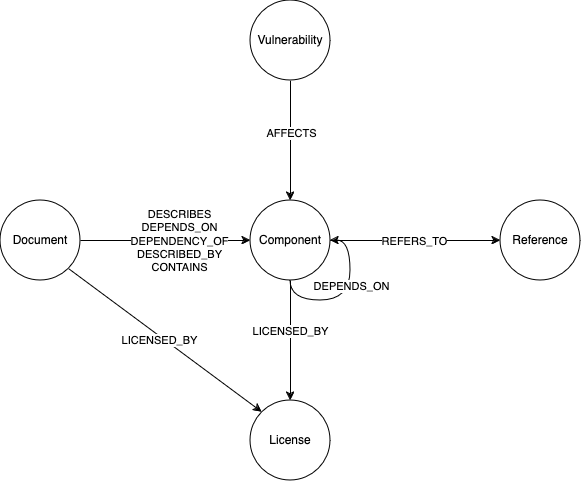

**Node Types**
* Document - This represents the SBOM document as well as the metadata associated with that SBOM.
* Component - This represents a specific component of a software system.
* Reference - This represents a reference to any external system which the system wanted to include as a reference. This can range from package managers, URLs to external websites, etc.
* Vulnerability - This represents a specific known vulnerability for a component.
* License - The license for the component or package.

**Edge Types**
* DESCRIBES/DEPENDS_ON/DEPENDENCY_OF/DESCRIBED_BY/CONTAINS - This represents the type of relationship between a Document and a Component in the system.
* REFERS_TO - This represents a reference between a Component and a Reference
* AFFECTS - This represents that a particular Component is affected by the connected Vulnerability

To run a question through this process we use the `retrieve` method of our retriever and pass it the question.
    </details>
</div>

In [ ]:
%%oc

<INSERT YOUR QUERY HERE>

<div class="alert alert-block alert-success"> 
<details>
    <summary>✅ <b><i>Click here to check your answer</i></b></summary>

Suggested Query:
    
    MATCH p=(d)-[]-(c:Component {name:  '<INSERT COMPONENT NAME HERE>'})-[]-(noe:Vulnerability)
        RETURN id(d) as document_id, noe.id as vulnerability_id, noe.`ratings.severity` as severity, 
        noe.`source.url` as reference
        ORDER by severity, document_id
    
</details>
</div>

Now that we have created our query, let's enter it into a new variable and use that to run a new `CypherTemplateRetriever` instance to answer our new question.

In [ ]:
try:
    COMPONENT_NEIGHBORHOOD_QUERY: str = """
            <INSERT QUERY FROM ABOVE>
        """

    retriever = CypherTemplateRetriever(graph_store, ComponentParams, COMPONENT_NEIGHBORHOOD_QUERY)

    nodes = retriever.retrieve("Find the documents and vulnerabilities associated with a component openldap?")
    for node in nodes:
        print(node.text)
except NeptuneQueryException as e:
    print(e)

Now that we have shown how to use an LLM to extract the key entities and run a query, let's see how we can leverage an LLM to determine the intent of a question and decide which query is appropriate to run.

## Leveraging the LLM to determine the intent of the question

One of the most powerful aspects of LLMs is their ability to understand language and intent.  When working on applications for defined domain querying we can leverage this capability to determine which of our defined actions and queries we should take based on the intent of the question the user asks.

To accomplish this we can leverage LlamaIndex to call our LLM, passing it a `PromptTemplate`, and the question to get a result.  

Let's start by creating the `PromptTemplate` asking our LLM to determine the intent of the question and map it to one of our supported queries.  When creating a prompt, words that are surrounded by curly braces (`{}`) are used as variables, which must be passed in at execution time.  In this prompt we will have one variable, the question.

<div class="alert alert-block alert-warning"> 
<details>
    <summary>💡 <b><i>Click here to learn more about PromptTemplates</i></b></summary>

A [`PromptTemplate`](https://docs.llamaindex.ai/en/stable/api_reference/prompts/#llama_index.core.prompts.PromptTemplate) is a class in LlamaIndex that is passed to an LLM to run a prediction on.  This class has the ability to supply multiple parameters to control how it is processed, however in this case we only need to provide it a string of the prompt.  In this case we have created a prompt that describes the specific types of queries we are allowing, a description of the action of each query, and the value to return.  
    
</details>
</div>



In [ ]:
INTENT_TEMPLATE = PromptTemplate("""You’re a LLM that detects intent from user questions for an application. 
Your task is to classify the user's intent based on their questions. 
Question:
{question}

Below are the possible intent name, followed by a colon, then brief descriptions. 

- COMPONENT_QUERY: Find information about a specific component

- COMPONENT_NEIGHBORHOOD_QUERY: Find information about vulnerabilities and documents connected to a component

- UNKNOWN: Choose this if the query doesn’t fall into any of the other intents.
    
Use these to accurately determine the user's goal, and output only the intent name.
 Do not provide any additional context or explanation.
 Component and Library are used as synonyms
""")

Now that we have created our prompt template we can pass this to the `predict` method, along with the question to get back the intended action.  


The `predict` method will take the provided `PromptTemplate`, the additional parameters, and combine them into a single context.  This context will then be passed to the LLM and the LLM will return the predicted intent.  

In the cell below we wrapped these steps in a method for easier reuse in subsequent cells.

In [ ]:
def predict_intent(question):
    return llm.predict(
        INTENT_TEMPLATE,
        question=question,
    )

print(predict_intent("Find me information about openldap?"))

If all has gone well we are getting back the expected query type.

For demonstration purposes the prompt constructed here is a basic example, for most applications the prompt needs to be much more specific around how to determine the appropriate query, especially as the number of options grows.  
When writing these prompts don't forget that:

* LLMs are non-deterministic so you need to ensure that your applications handles incorrect intent detection
* Don't forget to add a fallback option to handle situations where the intent is not clear, acceptable, or understood.
* Testing and evaluating prompts across many test cases is crucial for building intent detection

Let's try a few other questions and see how they respond.

In [ ]:
print(predict_intent("Find the documents and vulnerabilities connected to the component openldap?"))

In [ ]:
print(predict_intent("Delete all data in the database?"))

Now it's your turn, let's try variations of the questions above and see how well the LLM can determine the intent of your question.

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Try varying the wording and phrasing of the examples above and monitor how well the LLM does at determining the intent.
</div>

In [ ]:
print(predict_intent("<INSERT YOUR QUESTION HERE>"))

## Combining the pieces

So far we have built out the two pieces we need, the ability to prompt the model with a question and extract out the key entities to run as part of a predefined query and the ability to have an LLM determine the user's intent from a defined set of options, now it is time to put them together.

If we are building an interactive chat experience where the human is asking natural language questions, ideally we want to connect these two options together to provide a seamless experience for the end user.  To achieve this we just chain together the results of our `predict_intent` method above with the appropriate query.  Let's wrap these into a method so we can reuse this logic.

In [ ]:
def run_query(question):
    intent = predict_intent(question)
    if intent == "COMPONENT_QUERY":
        retriever = CypherTemplateRetriever(graph_store, ComponentParams, COMPONENT_QUERY)
    elif intent == "COMPONENT_NEIGHBORHOOD_QUERY":
        retriever = CypherTemplateRetriever(graph_store, ComponentParams, COMPONENT_NEIGHBORHOOD_QUERY)    
    else:
        print("The intent of your question is not known, Please rephrase the question and try again.")
        return
    try:
        nodes = retriever.retrieve(question)
        for node in nodes:
            print(node.text)
    except NeptuneQueryException as e:
        print(e)

run_query("Find me information about openldap?")

Let's inspect the response we got back. Let's try this with some other example questions.

In [ ]:
run_query("Find the documents and vulnerabilities associated with openldap?")

In [ ]:
run_query("Delete all data in the database")

Now it's your turn, let's try variations of the questions above and see how well the LLM can determine the intent of your question.

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Try varying the wording and phrasing of the examples above and monitor how well the LLM does at determining the intent.
</div>

In [ ]:
run_query("<INSERT YOUR QUESTION HERE>")

## Putting it all together

Now that we have all the pieces, we can combine them to produce a question and answer method that hides the complexity behind a very simple API that an application will use for interacting with LlamaIndex, Amazon Bedrock, and Neptune.

For this next section we are going to be modifying an incomplete version of our chatbot application to have it function for defined domain question and answering.

In Jupyter, navigate to the `app` subfolder and click on the file `DefinedDomainQA.py` to edit it.

![image.png](attachment:image.png)

Once you have loaded that file you will need to update the code in two places:

1. At the top of the method, please copy the `COMPONENT_NEIGHBORHOOD_QUERY` query you wrote above into the `COMPONENT_NEIGHBORHOOD_QUERY` variable in the file.

```
    COMPONENT_NEIGHBORHOOD_QUERY: str = """
        
    """  # UPDATE WITH THE QUERY FROM THE NOTEBOOK

```

<div class="alert alert-block alert-success"> 
<details>
    <summary>✏️ <b><i>Click here to check your answer</i></b></summary>

<code>
    COMPONENT_NEIGHBORHOOD_QUERY: str = """
        MATCH p=(d)-[]-(c:Component {name:  $component_name})-[]-(noe:Vulnerability)
        RETURN id(d) as document_id, noe.id as vulnerability_id, noe.`ratings.severity` as severity, 
        noe.`source.url` as reference
        ORDER by severity, document_id
    """ 
</code>

</details>
</div>


2. * Modify the `INTENT_TEMPLATE` variable to use the prompt template we developed above

```
  INTENT_TEMPLATE = PromptTemplate(
        """
        
        """  # UPDATE WITH THE PROMPT FROM THE NOTEBOOK
    )
```

<div class="alert alert-block alert-success"> 
<details>
    <summary>✏️ <b><i>Click here to check your answer</i></b></summary>

```
    INTENT_TEMPLATE = PromptTemplate("""You’re a LLM that detects intent from user questions for an application. 
    Your task is to classify the user's intent based on their questions. 
    Question:
    {question}

    Below are the possible intent name, followed by a colon, then brief descriptions. 

    - COMPONENT_QUERY: Find information about a specific component

    - COMPONENT_NEIGHBORHOOD_QUERY: Find information about vulnerabilities and documents connected to a component

    - UNKNOWN: Choose this if the query doesn’t fall into any of the other intents.

    Use these to accurately determine the user's goal, and output only the intent name.
     Do not provide any additional context or explanation.
     Component and Library are used as synonyms
    """)
```

</details>
</div>

Once you have made these changes you can proceed on to the cells below, which will run our Streamlit application locally so you can test out your application.  Once it is running please click on the "Click here to open the sample application" link to open a new browser tab pointing to your running application.

In [ ]:
%pip install -qqq -r ./app/requirements.txt jupyter-server-proxy jupyter-rsession-proxy

<div class="alert alert-warning">
<strong>⚠️ Notice</strong><hr>
    
If a <code>Note</code> or <code>Error</code> message appears after installing these packages, you can safely ignore these version incompatabilities and/or message to restart the notebook kernel.
</div>

In [ ]:
import subprocess

# Fetch the CloudFormation stack output
output_value = subprocess.check_output(
    ["aws", "cloudformation", "describe-stacks",
     "--stack-name", "workshop",
     "--query", "Stacks[0].Outputs[?OutputKey==`NotebookInstance`].OutputValue | [0]",
     "--output", "text"]
).decode().strip()
output_value += "proxy/8501/Defined_Domain_Question_Answering"

# Display the clickable link to the chat app
from IPython.display import Markdown

display(Markdown(f"<a href={output_value} target=\"_blank\">Click here to open the sample application</a>"))

!streamlit run ./app/Home.py --browser.gatherUsageStats false --browser.serverAddress 0.0.0.0 > /dev/null

<div class="alert alert-block alert-danger"> 
<strong>🛑</strong> You must stop the cell execution manually using the stop button on the control bar before moving on to the rest of this notebook.
</div>

## Summary

In this section we have demonstrated how you can use an LLM to determine the intent of a question and run a predefined query to satisfy that question.  

In certain internal applications, users may be granted unfettered access to the data. However, for most real-world deployments, organizations will likely want to implement some form of guardrails within the application. These guardrails help prevent unintended consequences, such as:

* Noisy neighbor problems: Where high-demand queries from some users impact the performance for others.
* Resource over-utilization: Ensuring individual users don’t monopolize shared computing resources.
* Data manipulation: Protecting the integrity of the underlying knowledge graph data.
* Inadvertent data exposure: Restricting access to sensitive or confidential information.

By carefully balancing flexibility and security, graph-powered Q&A systems can provide a robust and reliable user experience while maintaining appropriate controls over the application and data. The specific trade-offs and implementation details will depend on the context and requirements of each individual use case.

## Next Steps
We have completed the main sections on this notebook now you can either continue on with the optional sections below to learn more about this topic or you can move on to the next notebook.


**Continue to part 4 of the workshop in the [next notebook](4-Graph-Enhanced-RAG.ipynb).**

---
# Optional - Adding additional queries on a path to production

As we have seen, the defined domain approach is a great way to provide secure data access from natural language questions, but it has a downside. Specifically, each unique intent requires a separate retriever to be configured. 

For example, if we wanted to find out documents for a shared component, we would need to create a new query, a new parameter template, and retriever setup for that specific use case.  We would also need to update our prompt template to reflect the new potential intent.

Let's walk through the steps we performed above to add a new intent, "Find me all the documents that share component A and their vulnerabilities" to our application. 

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Write an openCypher query that will find all the documents that use a components and return the document and a list of the vulnerabilties. The component 'libssl3' is a good one to try this out on as it is shared by two documents.
</div>


<div class="alert alert-block alert-warning"> 
<details>
    <summary>💡 <b><i>Click here for a hint!</i></b></summary>
    
If you need guidance on how to write openCypher queries please check out the tutorial linked below.
    
[openCypher Basic Read Queries](../04-Language-Tutorials/02-openCypher/01-Basic-Read-Queries.ipynb)
    
</details>
</div>

In [ ]:
%%oc

<INSERT YOUR QUERY HERE>

<div class="alert alert-block alert-success"> 
<details>
    <summary>✏️ <b><i>Click here to check your answer</i></b></summary>

```
    MATCH (d:Document)-[]->(c:Component)<-[]-(noe:Vulnerability)
    WHERE toLower(c.name) = toLower('libssl3')
    RETURN d as documents, collect(noe) as vulnerabilities
```

</details>
</div>

Now let's enter our query into the area in the cell below.  In this case we are able to reuse our `ComponentParams` class for determing the component to use with our query.

In [ ]:
SHARED_COMPONENT_QUERY: str = """
        <INSERT QUERY FROM ABOVE>
    """

retriever = CypherTemplateRetriever(
    graph_store, ComponentParams, SHARED_COMPONENT_QUERY
)

try:
    nodes = retriever.retrieve(
        "Find me all the documents that share component libssl3 and their vulnerabilities?"
    )
    for node in nodes:
        print(node.text)
except NeptuneQueryException as e:
    print(e)

Next we need to update our `INTENT_TEMPLATE` to add our new intent.

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Update the prompt template we created earlier to include our new intent.  Make sure you check other questions as well to validate that the new template didn't break any existing intent logic.
</div>

In [ ]:
INTENT_TEMPLATE = PromptTemplate("""<INSERT PROMPT TEMPLATE HERE>""")

In [ ]:
print(
    predict_intent(
        "Find me all the documents that share component libssl3 and their vulnerabilities?"
    )
)

<div class="alert alert-block alert-success"> 
<details>
    <summary>✏️ <b><i>Click here to check your answer</i></b></summary>

```
INTENT_TEMPLATE = PromptTemplate("""You’re a LLM that detects intent from user questions for an application. 
Your task is to classify the user's intent based on their questions. 
Question:
{question}

Below are the possible intent name, followed by a colon, then brief descriptions. 

- COMPONENT_QUERY: Find information about a specific component

- COMPONENT_NEIGHBORHOOD_QUERY: Find information about vulnerabilities and documents connected to a component

- SHARED_COMPONENT_QUERY: Find information about documents that share a component

- UNKNOWN: Choose this if the query doesn’t fall into any of the other intents.
    
Use these to accurately determine the user's goal, and output only the intent name.
 Do not provide any additional context or explanation.
 Component and Library are used as synonyms
""")
```

</details>
</div>

Now let's enter our query into the area in the cell below.  In this case we are able to reuse our `ComponentParams` class for determining the parameters for our query.  Let's plug our new `INTENT_TEMPLATE` into our `run_query` method and try out our queries.

In [ ]:
run_query("Find me information about openldap?")

In [ ]:
run_query("Find the documents and vulnerabilities associated with openldap?")

In [ ]:
run_query("Delete all data in the database")

In [ ]:
run_query(
    "Find me all the documents that share component libssl3 and their vulnerabilities?"
)

Let's finish up this section by going back to our `DefineDomainQA.py` file and setting the `SHARED_COMPONENT_QUERY` variable to our query and updating the `INTENT_TEMPLATE` variable to our new prompt.

After updating the code and saving the file, run the cell below and see how our new query works in the application by typing it into the bar at the bottom and pressing `Enter`.

In [ ]:
import subprocess

# Fetch the CloudFormation stack output
output_value = subprocess.check_output(
    ["aws", "cloudformation", "describe-stacks",
     "--stack-name", "workshop",
     "--query", "Stacks[0].Outputs[?OutputKey==`NotebookInstance`].OutputValue | [0]",
     "--output", "text"]
).decode().strip()
output_value += "proxy/8501/Defined_Domain_Question_Answering"

# Display the clickable link to the chat app
from IPython.display import Markdown

display(Markdown(f"<a href={output_value} target=\"_blank\">Click here to open the sample application</a>"))

!streamlit run ./app/Home.py --browser.gatherUsageStats false --browser.serverAddress 0.0.0.0 > /dev/null


In this optional section we walked through how you can extend your defined intents to answer new questions.  Adding new intents is a common on-going piece of maintenance that will occur as the breadth and scope of the questions users ask evolves.  Over time this evolution will lead to a robust set of functionality that is secure and optimized for end users.